# Frequency of bus service on a particular route.

Humberto Ortiz-Zuazaga <humberto.ortiz@upr.edu>

We got some data from ["Autoridad Metropolitana de Autobuses"](https://es.wikipedia.org/wiki/Autoridad_Metropolitana_de_Autobuses), and I wanted to see what bus service to my neighborhood looks like. I picked a spot near my home, and grepped the data files for partial coordinates:

`$ cat AMA20140[12345].txt  | grep ",18370" | grep ",-66066" > parana-big.txt`

The data is a csv file with vehicle number, date and time, latitude, longitude, speed (km/h), and a code (1 for in motion, 2 for stopped, 4 for off):

    $ head parana.txt 
    823,20140107205422,18370866,-66066824,25,1
    823,20140107205427,18370545,-66066850,24,1
    823,20140107205432,18370246,-66066868,20,1
    823,20140116154618,18370701,-66066830,18,1
    823,20140116154623,18370535,-66066846,7,1
    823,20140116154703,18370331,-66066865,19,1
    823,20140116154708,18370140,-66066874,18,1
    823,20140116161308,18370128,-66066767,5,1
    823,20140116161318,18370310,-66066757,7,1
    823,20140116161356,18370485,-66066739,12,1

This particular file has 16773 lines.

In [1]:
%matplotlib inline

In [2]:
import csv
from datetime import datetime, timedelta

def timeparse(ds):
    timestamp = datetime.strptime(ds, "%Y%m%d%H%M%S")
    #return "{0}-{1}-{2}T{3}:{4}:{5}Z".format(year, month, day, hh, mm, ss)
    return timestamp

counts = [0] * 24
trips = []
times = []

last = datetime.fromordinal(1)
epsilon = timedelta(minutes=15) # it takes around 20 minutes for the bus to come back
lastbus = 0

with open('parana-big.txt', 'rb') as csvfile:
    amareader = csv.reader(csvfile)

    for row in amareader:
        timestamp = timeparse(row[1])
        bus = row[0]
        tdiff = abs(timestamp - last)
        
        # make sure it's a different bus, not the same stuck in traffic
        # the data is sorted by vehicle number, then date
        if tdiff > epsilon or bus != lastbus:
            # print timestamp, last, row
            lastbus = bus
            last = timestamp
            hour = timestamp.hour
            counts[hour] += 1
            trips.append(timestamp)

            midnight = timestamp.replace(hour=0, minute=0, second=0)
            diff = timestamp - midnight
            times.append(diff.total_seconds())


In [3]:
counts

[0,
 0,
 0,
 0,
 0,
 84,
 189,
 185,
 290,
 326,
 297,
 305,
 280,
 219,
 249,
 260,
 244,
 248,
 288,
 226,
 137,
 140,
 4,
 0]

My niece is always complaining there was no service between 11:00 AM and 2:00 PM. Let's just have a quick look to see if there really is no service:

(0, 24)

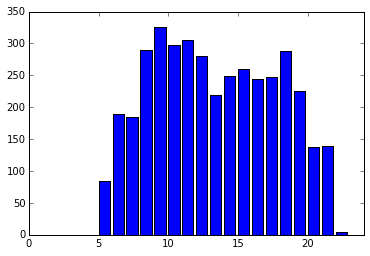

In [4]:
from pylab import *
bar(range(24), counts)
xlim(0,24)

That's actually not so bad. There is a lull in service at 1:00 PM, but busses seem to still be running. Let's dig a little deeper. We have the timestamp of each trip recorded, but they're not in order.

In [5]:
trips[:10]

[datetime.datetime(2014, 1, 7, 20, 54, 22),
 datetime.datetime(2014, 1, 16, 15, 46, 18),
 datetime.datetime(2014, 1, 16, 16, 13, 8),
 datetime.datetime(2014, 1, 16, 17, 42, 53),
 datetime.datetime(2014, 1, 16, 18, 11, 5),
 datetime.datetime(2014, 1, 16, 19, 23, 4),
 datetime.datetime(2014, 1, 16, 19, 49, 19),
 datetime.datetime(2014, 1, 21, 20, 14, 46),
 datetime.datetime(2014, 1, 21, 20, 33, 16),
 datetime.datetime(2014, 1, 26, 14, 25, 12)]

In [6]:
trips.sort() # sort by datetime
trips[:10]

[datetime.datetime(2014, 1, 1, 6, 0, 38),
 datetime.datetime(2014, 1, 1, 7, 47, 43),
 datetime.datetime(2014, 1, 1, 8, 3, 2),
 datetime.datetime(2014, 1, 1, 9, 24, 47),
 datetime.datetime(2014, 1, 1, 9, 42, 20),
 datetime.datetime(2014, 1, 1, 10, 21, 24),
 datetime.datetime(2014, 1, 1, 11, 42, 16),
 datetime.datetime(2014, 1, 1, 12, 0, 3),
 datetime.datetime(2014, 1, 1, 14, 25, 42),
 datetime.datetime(2014, 1, 1, 14, 46, 20)]

Now that the timestamps are sorted, we can check how long a person that just missed a bus will wait for the next one.

In [7]:
intervals = [0] * 24
counts = [0] * 24

for i in range(1, len(trips)):
    wait = trips[i] - trips[i-1] # how long since the last bus?
    hour = trips[i].hour
    # count how many hours you waited if you missed the last bus
    intervals[hour] += wait.seconds / 60.0**2
    counts[hour] += 1

Now we can compute the average wait time per hour blocks.

In [8]:
for i in range(24):
    if counts[i]: # don't divide by zero
        intervals[i] = intervals[i] / counts[i]

intervals

[0,
 0,
 0,
 0,
 0,
 8.622622354497352,
 3.153795803782506,
 0.8821351351351358,
 0.810387931034482,
 0.463052999318337,
 0.5035867938645715,
 0.5140938069216753,
 0.5337867063492059,
 0.7208447488584477,
 0.5765662650602411,
 0.5386944444444447,
 0.5876366120218577,
 0.6004446684587816,
 0.49911554783950596,
 0.6116285644051129,
 0.6619282238442825,
 1.1397162698412688,
 0.8788888888888888,
 0]

(0, 24)

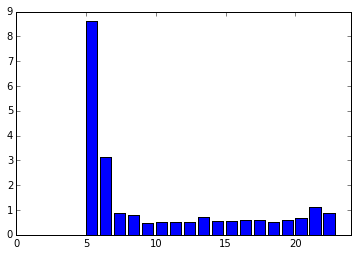

In [9]:
bar(range(24), intervals)
xlim(0,24)

In [10]:
len(trips)

3971

(0, 86400)

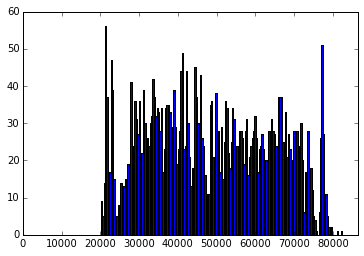

In [11]:
import numpy as np
day = 24 * 60 * 60
bins = np.arange(day / (6 * 60) ,dtype = np.float_) * 6 * 60
plt = hist(times, bins)
xlim(0, 240 * 6* 60)

In [12]:
trips[:20]


[datetime.datetime(2014, 1, 1, 6, 0, 38),
 datetime.datetime(2014, 1, 1, 7, 47, 43),
 datetime.datetime(2014, 1, 1, 8, 3, 2),
 datetime.datetime(2014, 1, 1, 9, 24, 47),
 datetime.datetime(2014, 1, 1, 9, 42, 20),
 datetime.datetime(2014, 1, 1, 10, 21, 24),
 datetime.datetime(2014, 1, 1, 11, 42, 16),
 datetime.datetime(2014, 1, 1, 12, 0, 3),
 datetime.datetime(2014, 1, 1, 14, 25, 42),
 datetime.datetime(2014, 1, 1, 14, 46, 20),
 datetime.datetime(2014, 1, 1, 16, 23, 52),
 datetime.datetime(2014, 1, 1, 16, 41, 24),
 datetime.datetime(2014, 1, 1, 18, 52, 19),
 datetime.datetime(2014, 1, 1, 19, 17, 46),
 datetime.datetime(2014, 1, 1, 20, 32, 53),
 datetime.datetime(2014, 1, 2, 5, 57, 45),
 datetime.datetime(2014, 1, 2, 6, 18, 36),
 datetime.datetime(2014, 1, 2, 7, 36, 41),
 datetime.datetime(2014, 1, 2, 7, 57, 8),
 datetime.datetime(2014, 1, 2, 8, 27, 57)]

In [13]:
trips[15:15+30]

[datetime.datetime(2014, 1, 2, 5, 57, 45),
 datetime.datetime(2014, 1, 2, 6, 18, 36),
 datetime.datetime(2014, 1, 2, 7, 36, 41),
 datetime.datetime(2014, 1, 2, 7, 57, 8),
 datetime.datetime(2014, 1, 2, 8, 27, 57),
 datetime.datetime(2014, 1, 2, 8, 50, 43),
 datetime.datetime(2014, 1, 2, 9, 25, 1),
 datetime.datetime(2014, 1, 2, 9, 49, 5),
 datetime.datetime(2014, 1, 2, 10, 27, 22),
 datetime.datetime(2014, 1, 2, 10, 35, 17),
 datetime.datetime(2014, 1, 2, 10, 49, 56),
 datetime.datetime(2014, 1, 2, 11, 24, 16),
 datetime.datetime(2014, 1, 2, 11, 47, 41),
 datetime.datetime(2014, 1, 2, 12, 22, 47),
 datetime.datetime(2014, 1, 2, 12, 46, 43),
 datetime.datetime(2014, 1, 2, 13, 27, 5),
 datetime.datetime(2014, 1, 2, 13, 50, 50),
 datetime.datetime(2014, 1, 2, 14, 46, 18),
 datetime.datetime(2014, 1, 2, 15, 16, 24),
 datetime.datetime(2014, 1, 2, 15, 53, 6),
 datetime.datetime(2014, 1, 2, 16, 14, 52),
 datetime.datetime(2014, 1, 2, 16, 41, 11),
 datetime.datetime(2014, 1, 2, 16, 42, 52),
 